# High-Level Setup & Imports

In [48]:
# General Python Packages
import os, time, numbers, math

# Torch Packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torch import nn
from torch.nn import DataParallel
from torch.nn import Module

# General Analytics Packages
import pandas as pd
import numpy as np

# Visualization / Image Packages
import matplotlib.pyplot as plt
from PIL import Image

# Randomization Functions
from random import random as randuni

In [49]:
# Put MatPlotLib in interactive mode
plt.ion()

# Plot graphics inline in the notebook
%matplotlib inline

# Define Classes and Functions

### Image Data Utility Classes

In [50]:
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    """ TODO: Research paper also excludes these labels but need to figure out how to handle
              cases that have these as positive findings (completely exclude?)
    excluded_labels = ['Edema','Hernia','Emphysema','Fibrosis','No Finding'
                      'Pleural_Thickening','Consolidation']
    """
    excluded_labels = ['No Finding']
    
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
    
    # Drop some label that we do not want to include
    unique_labels = [l for l in unique_labels if l not in excluded_labels]

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
def imshow(inp, title=None):
    """ Convert tensor array to an image (only use post-dataset transform) """
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Torch Dataset Definition

In [51]:
class XrayImageSet(Dataset):
    """
    Args:
        image_root (string): root directory of the images in form image/subfolder/*.png
        csv_file (string): path to the CSV data file
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        labels (list): list of the possible label names.
        label_to_index (dict): look from label name to a label index
        imgs (list): List of (filename, image path) tuples
    """
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """ Calculate length of the dataset (number of images) """
        return len(self.imgs)
    
    def get_labels(self, fname):
        """ Return the label string for the file """
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        """ Convert the labels string (with each label separated by |) into 1-hot encoding """
        if labels == None:
            return None
        
        split_label_indices = [self.label_to_index.get(label)
                               for label in labels.split('|')
                               if label != 'No Finding']
        
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        """ Get the 1-hot encoded label array for the provided file """
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return torch.FloatTensor(one_hot_labels)

### Model Training Output Writer

In [52]:
class printer_writer:
    def __init__(self, output_folder_path):
        self.start_time = time.strftime('%Y%m%d-%Hh%Mm%Ss')
        
        self.outprefix = output_folder_path + '/' + self.start_time
        
        # Print Output File
        self.print_out_path = self.outprefix + '_print.txt'
        self.print_out_file = open(self.print_out_path, 'w', 1)
        
    def printw(self, string):
        print(string)
        try:
            self.print_out_file.write(string + "\n")
        except: # Ignore errors
            pass
        
    def save_checkpoint(self, epoch, model, optimizer, scheduler, val_error):
        model_out_path = self.outprefix + '_model_' + str(epoch+1) + '.tar'
        
        torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
        
    def close(self):
        self.print_out_file.close()

### Model Training Procedure

In [98]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, outfolder = '/user/xrayproj/output/'):
    since = time.time()
    scribe = printer_writer(outfolder)

    for epoch in range(num_epochs):
        scribe.printw('Epoch {}/{}'.format(epoch, num_epochs - 1))
        scribe.printw('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            obs_counter = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Store statistics (convert from autograd.Variable to float/int)
                loss_val = loss.data[0]
                correct_val = torch.sum( ((outputs.sigmoid()>0.5) == (labels>0.5)).long() ).data[0]
                
                running_loss += loss_val
                running_corrects += correct_val
                
                obs_counter += len(inputs)
                
                batch_loss = 1.0 * loss_val / len(inputs)
                batch_acc = 1.0 * correct_val / len(inputs)
                status = ' |~~ {}@{}  Loss: {:.6f} Acc: {:.4f}'.format(
                    phase, obs_counter, batch_loss, batch_acc)
                scribe.printw(status)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            scribe.printw('{}  Loss: {:.6f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Store the model on disk
            if phase == 'val':
                scheduler.step(epoch_loss)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scribe.save_checkpoint(epoch, model, optimizer, None, epoch_loss)
                else:
                    scribe.save_checkpoint(epoch, model, optimizer, scheduler, epoch_loss)

    time_elapsed = time.time() - since
    scribe.printw('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    scribe.close()

    return model

### Customized Binary Cross Entropy Loss Function

In [54]:
class BCEWithLogitsImbalanceWeightedLoss(Module):
    def __init__(self, class_weight=None, size_average=True):
        super(BCEWithLogitsImbalanceWeightedLoss, self).__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return self.imbalance_weighted_bce_with_logit(input, target, size_average=self.size_average)
    
    def imbalance_weighted_bce_with_logit(self, input, target, size_average=True):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # Determine |P| and |N|
        positive_labels = target.sum()
        negative_labels = (1-target).sum()

        # Upweight the less common class (very often the 1s)
        beta_p = (positive_labels + negative_labels) / positive_labels
        beta_n = (positive_labels + negative_labels) / negative_labels

        # Adjust the losses accordingly
        loss_weight = target * beta_p + (1-target) * beta_n

        loss = loss * loss_weight

        if size_average:
            return loss.mean()
        else:
            return loss.sum()

### Model Evaluation Helper Classes

In [55]:
class TotalSumMeter:
    def __init__(self):
        self.obs_counter = 0.0
        self.total_pred = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        self.total_act = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        
    def update(self, preds, actuals):
        self.total_act += actuals.sum(0).cpu()
        self.total_pred += preds.sum(0).cpu()
        self.obs_counter += len(actuals)
        
    def get_results(self):
        return {
            'pred': self.total_pred / self.obs_counter,
            'act': self.total_act / self.obs_counter
            }

In [56]:
class MultiClassAUCMeter:
    """ Wrapper on the normal AUCMeter to handle multi-class predictions """
    def __init__(self, num_class):
        self.num_class = num_class
        self.meters = []
        for i in range(self.num_class):
            self.meters.append(AUCMeter())

    def add(self, output, target):
        for i in range(self.num_class):
            self.meters[i].add(output[:,i], target[:,i])
        
    def value(self):
        output = []
        for i in range(self.num_class):
            output.append(self.meters[i].value())
        return output

In [57]:
class AUCMeter:
    """
    SOURCE: https://github.com/pytorch/tnt/blob/master/torchnet/meter/aucmeter.py
    
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """
    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)

In [58]:
class ModelEvaluator:
    def __init__(self, model, dataset, num_classes = 14):
        self.model = model
        self.dataset = dataset
        self.num_classes = num_classes
        self.is_run = False
        
    def score_obs(self, data_row):
        inputs, actuals = data_row

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()
        
        return preds, actuals
    
    def run(self, force_rerun = False):
        if self.is_run and not force_rerun:
            print("Already evaluated this...")
            return None
        
        self.model.train(False)
    
        self.m_total_sums = TotalSumMeter()
        self.m_auc = MultiClassAUCMeter(self.num_classes)

        for data in self.dataset:
            preds, actuals = self.score_obs(data)

            self.m_total_sums.update(preds, actuals)
            self.m_auc.add(preds.data, actuals.data)

### Plotting Functions for Model Evaluations

In [59]:
def plot_auc_bar(in_evaluator):
    auc_out = in_evaluator.m_auc.value()
    plt.bar(range(14), [v for v, _, _ in auc_out])

In [128]:
def plot_auc_curves(in_evaluator):
    index_to_label = {idx: val for val, idx in img_data_train.label_to_index.items()}
    auc_out = in_evaluator.m_auc.value()
    
    plt.figure(figsize=(10,8))

    for idx, (auc, tpr, fpr) in enumerate(auc_out):
        disease = index_to_label[idx]
        plt.plot(fpr, tpr, label="{0} (AUC: {1:0.3f})".format(disease, auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Disease')
    plt.legend(loc="lower right")
    plt.show()

In [61]:
def plot_compare_sums(in_evaluator, bar_width = 0.4):
    sums_out = in_evaluator.m_total_sums.get_results()
    
    act = sums_out['act'].data.numpy()
    pred = sums_out['pred'].data.numpy()
    
    indx1 = range(14)
    indx2 = [i+bar_width for i in indx1]

    plt.bar(indx1, act,  width=bar_width, label="Actual")
    plt.bar(indx2, pred, width=bar_width, label="Predicted")
    
    plt.xticks(indx1, img_data_train.labels, rotation=90)
    plt.legend()

### Define model types

In [69]:
def ResNetBase(base_size = 18, only_update_fc = True):
    """ ResNet 18 with only final FC layer updatable """
    m = None
    if base_size == 18:
        m = models.resnet18(pretrained=True)
    elif base_size == 34:
        m = models.resnet34(pretrained=True)
    elif base_size == 50:
        m = models.resnet50(pretrained=True)
    elif base_size == 101:
        m = models.resnet101(pretrained=True)
    elif base_size == 152:
        m = models.resnet152(pretrained=True)
    
    if only_update_fc:
        for param in m.parameters():
            param.requires_grad = False

    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [70]:
def BrandNewArchitecture():
    m = nn.Sequential(
            nn.Conv2d(1, 8, 2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Linear(H, D_out)
        )
    
    return m

#### mean ± std. dev. of 7 runs, 10000000 loops each

#### Time for __get_item__
```
%timeit img_data_train[3] # 30.8 ms ± 544 µs per loop
```

#### Breakdown for __get_item__
```
%timeit img_data_train.imgs[8] # 63 ns ± 0.0057 ns per loop
%timeit img_data_train.get_one_hot_labels('00011558_012.png') # 8.72 ms ± 9.44 µs per loop
%timeit img_data_train.loader('/user/images/images_006/00011558_012.png') # 14.1 ms ± 3.41 µs per loop
%timeit img_data_train.transform(img) # 3.17 ms ± 1.32 µs per loop
```

#### Breakdown for loader() from __get_item__
```
%timeit open('/user/images/images_006/00011558_012.png', 'rb') # 7.72 µs ± 13.4 ns per loop
%timeit Image.open(f) # 37.5 µs ± 2.25 µs per loop
%timeit img.convert('RGB') # 498 µs ± 149 ns per loop
```

# Setup and Begin Training Model

### Data Setup

In [62]:
nn_input_size = 224 #1024
batch_size = 64
pin_mem_setting = True
num_gpus = torch.cuda.device_count()
num_workers = 10

print("Number of GPU: {}".format(num_gpus))

Number of GPU: 1


In [63]:
img_transforms = transforms.Compose(
    [transforms.Resize(nn_input_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [64]:
img_data_train = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_train.imgs = [img for i, img in enumerate(img_data_train.imgs) if i % 10 > 0]# and randuni() < 0.1]

In [65]:
img_data_val   = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_val.imgs = [img for i, img in enumerate(img_data_val.imgs) if i % 10 == 0]# and randuni() < 0.1]

In [66]:
print("Training Set Size: {}".format(len(img_data_train)))
print("Validation Set Size: {}".format(len(img_data_val)))

Training Set Size: 100908
Validation Set Size: 11212


In [67]:
img_loader_train = DataLoader(img_data_train,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

img_loader_val   = DataLoader(img_data_val,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

In [68]:
dataloaders = {
    'train': img_loader_train,
    'val': img_loader_val
}

In [71]:
model_base = ResNetBase(base_size = 18, only_update_fc = False)

In [45]:
model_ft = DataParallel(model_base).cuda()

### Setup learning rates and procedures

In [72]:
#criterion = BCEWithLogitsImbalanceWeightedLoss()
criterion_base = nn.BCEWithLogitsLoss()

#optimizer_ft = SGD(model_ft.module.fc.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
learning_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=1)

In [73]:
criterion = criterion_base.cuda()

### Future code for allowing optimization of the base layer with a lower learning rate

```
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': opt.lr}
        ], lr=opt.lr*0.1, momentum=0.9)
```

# Begin Training Network (Normal Cost)

In [120]:
train_model(model_ft,
            criterion,
            optimizer_ft,
            learning_scheduler,
            num_epochs=2)

Epoch 0/1
----------
 |~~ train@64  Loss: 0.002463 Acc: 13.2656
 |~~ train@128  Loss: 0.001988 Acc: 13.4219
 |~~ train@192  Loss: 0.002078 Acc: 13.2656
 |~~ train@256  Loss: 0.002365 Acc: 13.3125
 |~~ train@320  Loss: 0.002627 Acc: 13.1875
 |~~ train@384  Loss: 0.001576 Acc: 13.5625
 |~~ train@448  Loss: 0.001804 Acc: 13.3281
 |~~ train@512  Loss: 0.002008 Acc: 13.3750
 |~~ train@576  Loss: 0.001893 Acc: 13.3125
 |~~ train@640  Loss: 0.002294 Acc: 13.2500
 |~~ train@704  Loss: 0.002093 Acc: 13.2344
 |~~ train@768  Loss: 0.002068 Acc: 13.3594
 |~~ train@832  Loss: 0.002138 Acc: 13.3906
 |~~ train@896  Loss: 0.002526 Acc: 13.0625
 |~~ train@960  Loss: 0.002285 Acc: 13.2188
 |~~ train@1024  Loss: 0.001934 Acc: 13.2969
 |~~ train@1088  Loss: 0.002663 Acc: 13.0469
 |~~ train@1152  Loss: 0.001951 Acc: 13.3281
 |~~ train@1216  Loss: 0.002644 Acc: 13.1406
 |~~ train@1280  Loss: 0.001904 Acc: 13.4062
 |~~ train@1344  Loss: 0.002883 Acc: 13.1250
 |~~ train@1408  Loss: 0.001809 Acc: 13.4531
 |~~ 

 |~~ train@11712  Loss: 0.001642 Acc: 13.3906
 |~~ train@11776  Loss: 0.001732 Acc: 13.4062
 |~~ train@11840  Loss: 0.001962 Acc: 13.3750
 |~~ train@11904  Loss: 0.002271 Acc: 13.3125
 |~~ train@11968  Loss: 0.002451 Acc: 13.2812
 |~~ train@12032  Loss: 0.002044 Acc: 13.3281
 |~~ train@12096  Loss: 0.002147 Acc: 13.2969
 |~~ train@12160  Loss: 0.001626 Acc: 13.5625
 |~~ train@12224  Loss: 0.001716 Acc: 13.3906
 |~~ train@12288  Loss: 0.001531 Acc: 13.4844
 |~~ train@12352  Loss: 0.002241 Acc: 13.1875
 |~~ train@12416  Loss: 0.002114 Acc: 13.2969
 |~~ train@12480  Loss: 0.001741 Acc: 13.4688
 |~~ train@12544  Loss: 0.002226 Acc: 13.3438
 |~~ train@12608  Loss: 0.001880 Acc: 13.4062
 |~~ train@12672  Loss: 0.002078 Acc: 13.3906
 |~~ train@12736  Loss: 0.001832 Acc: 13.4688
 |~~ train@12800  Loss: 0.002439 Acc: 13.3125
 |~~ train@12864  Loss: 0.002014 Acc: 13.3438
 |~~ train@12928  Loss: 0.001790 Acc: 13.5000
 |~~ train@12992  Loss: 0.002283 Acc: 13.3125
 |~~ train@13056  Loss: 0.002388 A

 |~~ train@23296  Loss: 0.002243 Acc: 13.2656
 |~~ train@23360  Loss: 0.002359 Acc: 13.2812
 |~~ train@23424  Loss: 0.002124 Acc: 13.3125
 |~~ train@23488  Loss: 0.002354 Acc: 13.1406
 |~~ train@23552  Loss: 0.002152 Acc: 13.3281
 |~~ train@23616  Loss: 0.001738 Acc: 13.4688
 |~~ train@23680  Loss: 0.002038 Acc: 13.2969
 |~~ train@23744  Loss: 0.002518 Acc: 13.1719
 |~~ train@23808  Loss: 0.002200 Acc: 13.2812
 |~~ train@23872  Loss: 0.002245 Acc: 13.2188
 |~~ train@23936  Loss: 0.002071 Acc: 13.2500
 |~~ train@24000  Loss: 0.001804 Acc: 13.4375
 |~~ train@24064  Loss: 0.002073 Acc: 13.3750
 |~~ train@24128  Loss: 0.002107 Acc: 13.2188
 |~~ train@24192  Loss: 0.002228 Acc: 13.3438
 |~~ train@24256  Loss: 0.001710 Acc: 13.4688
 |~~ train@24320  Loss: 0.002239 Acc: 13.3125
 |~~ train@24384  Loss: 0.001661 Acc: 13.4844
 |~~ train@24448  Loss: 0.002447 Acc: 13.2344
 |~~ train@24512  Loss: 0.002013 Acc: 13.3281
 |~~ train@24576  Loss: 0.002132 Acc: 13.2344
 |~~ train@24640  Loss: 0.001875 A

 |~~ train@34880  Loss: 0.001884 Acc: 13.3750
 |~~ train@34944  Loss: 0.002175 Acc: 13.2500
 |~~ train@35008  Loss: 0.001624 Acc: 13.5781
 |~~ train@35072  Loss: 0.002549 Acc: 13.1094
 |~~ train@35136  Loss: 0.002502 Acc: 13.1250
 |~~ train@35200  Loss: 0.002227 Acc: 13.2344
 |~~ train@35264  Loss: 0.002194 Acc: 13.2500
 |~~ train@35328  Loss: 0.002501 Acc: 13.2344
 |~~ train@35392  Loss: 0.001713 Acc: 13.4375
 |~~ train@35456  Loss: 0.002143 Acc: 13.3125
 |~~ train@35520  Loss: 0.002587 Acc: 13.1406
 |~~ train@35584  Loss: 0.002297 Acc: 13.2188
 |~~ train@35648  Loss: 0.002198 Acc: 13.2812
 |~~ train@35712  Loss: 0.002366 Acc: 13.2188
 |~~ train@35776  Loss: 0.002021 Acc: 13.4219
 |~~ train@35840  Loss: 0.001609 Acc: 13.5000
 |~~ train@35904  Loss: 0.001838 Acc: 13.4375
 |~~ train@35968  Loss: 0.001944 Acc: 13.4375
 |~~ train@36032  Loss: 0.001971 Acc: 13.3906
 |~~ train@36096  Loss: 0.002275 Acc: 13.2969
 |~~ train@36160  Loss: 0.001697 Acc: 13.4062
 |~~ train@36224  Loss: 0.002082 A

 |~~ train@46336  Loss: 0.001879 Acc: 13.3281
 |~~ train@46400  Loss: 0.002143 Acc: 13.2969
 |~~ train@46464  Loss: 0.002107 Acc: 13.3438
 |~~ train@46528  Loss: 0.002116 Acc: 13.2656
 |~~ train@46592  Loss: 0.001830 Acc: 13.3281
 |~~ train@46656  Loss: 0.002343 Acc: 13.1719
 |~~ train@46720  Loss: 0.002008 Acc: 13.4688
 |~~ train@46784  Loss: 0.002139 Acc: 13.2500
 |~~ train@46848  Loss: 0.002343 Acc: 13.1719
 |~~ train@46912  Loss: 0.001961 Acc: 13.3906
 |~~ train@46976  Loss: 0.002138 Acc: 13.2969
 |~~ train@47040  Loss: 0.001559 Acc: 13.6094
 |~~ train@47104  Loss: 0.002048 Acc: 13.2812
 |~~ train@47168  Loss: 0.001668 Acc: 13.3906
 |~~ train@47232  Loss: 0.002182 Acc: 13.2812
 |~~ train@47296  Loss: 0.002051 Acc: 13.3594
 |~~ train@47360  Loss: 0.002132 Acc: 13.3594
 |~~ train@47424  Loss: 0.001837 Acc: 13.4219
 |~~ train@47488  Loss: 0.002396 Acc: 13.1719
 |~~ train@47552  Loss: 0.002581 Acc: 13.0312
 |~~ train@47616  Loss: 0.001723 Acc: 13.4844
 |~~ train@47680  Loss: 0.001922 A

 |~~ train@57792  Loss: 0.002049 Acc: 13.3438
 |~~ train@57856  Loss: 0.002012 Acc: 13.3594
 |~~ train@57920  Loss: 0.002071 Acc: 13.2656
 |~~ train@57984  Loss: 0.001906 Acc: 13.4062
 |~~ train@58048  Loss: 0.001576 Acc: 13.5312
 |~~ train@58112  Loss: 0.001616 Acc: 13.4375
 |~~ train@58176  Loss: 0.001781 Acc: 13.4375
 |~~ train@58240  Loss: 0.001733 Acc: 13.5000
 |~~ train@58304  Loss: 0.001922 Acc: 13.3438
 |~~ train@58368  Loss: 0.001793 Acc: 13.4375
 |~~ train@58432  Loss: 0.002233 Acc: 13.2969
 |~~ train@58496  Loss: 0.002026 Acc: 13.3125
 |~~ train@58560  Loss: 0.002360 Acc: 13.2344
 |~~ train@58624  Loss: 0.002149 Acc: 13.2812
 |~~ train@58688  Loss: 0.002050 Acc: 13.3438
 |~~ train@58752  Loss: 0.001753 Acc: 13.4531
 |~~ train@58816  Loss: 0.002109 Acc: 13.2812
 |~~ train@58880  Loss: 0.002014 Acc: 13.3438
 |~~ train@58944  Loss: 0.002543 Acc: 13.2500
 |~~ train@59008  Loss: 0.001920 Acc: 13.3125
 |~~ train@59072  Loss: 0.002080 Acc: 13.4531
 |~~ train@59136  Loss: 0.001511 A

 |~~ train@69248  Loss: 0.002090 Acc: 13.2812
 |~~ train@69312  Loss: 0.002002 Acc: 13.2969
 |~~ train@69376  Loss: 0.002010 Acc: 13.4375
 |~~ train@69440  Loss: 0.002026 Acc: 13.3594
 |~~ train@69504  Loss: 0.001993 Acc: 13.3281
 |~~ train@69568  Loss: 0.002051 Acc: 13.3125
 |~~ train@69632  Loss: 0.002438 Acc: 13.3281
 |~~ train@69696  Loss: 0.002061 Acc: 13.3438
 |~~ train@69760  Loss: 0.001869 Acc: 13.3438
 |~~ train@69824  Loss: 0.001964 Acc: 13.2812
 |~~ train@69888  Loss: 0.002077 Acc: 13.2656
 |~~ train@69952  Loss: 0.001929 Acc: 13.3438
 |~~ train@70016  Loss: 0.002386 Acc: 13.2344
 |~~ train@70080  Loss: 0.001923 Acc: 13.4844
 |~~ train@70144  Loss: 0.002427 Acc: 13.2188
 |~~ train@70208  Loss: 0.001994 Acc: 13.3438
 |~~ train@70272  Loss: 0.002330 Acc: 13.2969
 |~~ train@70336  Loss: 0.001736 Acc: 13.5000
 |~~ train@70400  Loss: 0.001926 Acc: 13.3438
 |~~ train@70464  Loss: 0.002231 Acc: 13.2344
 |~~ train@70528  Loss: 0.001761 Acc: 13.3281
 |~~ train@70592  Loss: 0.001886 A

 |~~ train@80832  Loss: 0.001941 Acc: 13.3281
 |~~ train@80896  Loss: 0.002251 Acc: 13.2500
 |~~ train@80960  Loss: 0.001772 Acc: 13.4062
 |~~ train@81024  Loss: 0.001861 Acc: 13.3594
 |~~ train@81088  Loss: 0.002088 Acc: 13.3438
 |~~ train@81152  Loss: 0.002345 Acc: 13.2656
 |~~ train@81216  Loss: 0.002360 Acc: 13.2344
 |~~ train@81280  Loss: 0.001883 Acc: 13.3281
 |~~ train@81344  Loss: 0.001817 Acc: 13.4219
 |~~ train@81408  Loss: 0.002559 Acc: 13.1094
 |~~ train@81472  Loss: 0.001675 Acc: 13.5156
 |~~ train@81536  Loss: 0.002036 Acc: 13.3281
 |~~ train@81600  Loss: 0.001794 Acc: 13.4062
 |~~ train@81664  Loss: 0.001859 Acc: 13.4688
 |~~ train@81728  Loss: 0.001725 Acc: 13.5312
 |~~ train@81792  Loss: 0.001670 Acc: 13.4844
 |~~ train@81856  Loss: 0.002142 Acc: 13.2812
 |~~ train@81920  Loss: 0.001921 Acc: 13.3906
 |~~ train@81984  Loss: 0.002168 Acc: 13.2344
 |~~ train@82048  Loss: 0.001726 Acc: 13.3438
 |~~ train@82112  Loss: 0.002349 Acc: 13.2500
 |~~ train@82176  Loss: 0.001870 A

 |~~ train@92288  Loss: 0.002087 Acc: 13.2969
 |~~ train@92352  Loss: 0.002076 Acc: 13.3125
 |~~ train@92416  Loss: 0.002187 Acc: 13.2188
 |~~ train@92480  Loss: 0.002098 Acc: 13.2969
 |~~ train@92544  Loss: 0.002374 Acc: 13.0938
 |~~ train@92608  Loss: 0.001874 Acc: 13.3750
 |~~ train@92672  Loss: 0.002199 Acc: 13.2812
 |~~ train@92736  Loss: 0.002139 Acc: 13.2812
 |~~ train@92800  Loss: 0.001604 Acc: 13.5312
 |~~ train@92864  Loss: 0.002882 Acc: 13.0625
 |~~ train@92928  Loss: 0.002321 Acc: 13.2969
 |~~ train@92992  Loss: 0.002032 Acc: 13.3125
 |~~ train@93056  Loss: 0.002299 Acc: 13.1719
 |~~ train@93120  Loss: 0.002121 Acc: 13.3438
 |~~ train@93184  Loss: 0.002717 Acc: 13.1250
 |~~ train@93248  Loss: 0.002478 Acc: 13.1250
 |~~ train@93312  Loss: 0.002007 Acc: 13.3906
 |~~ train@93376  Loss: 0.002051 Acc: 13.3438
 |~~ train@93440  Loss: 0.001876 Acc: 13.4688
 |~~ train@93504  Loss: 0.002553 Acc: 13.1719
 |~~ train@93568  Loss: 0.001991 Acc: 13.3281
 |~~ train@93632  Loss: 0.001821 A

 |~~ val@3072  Loss: 0.001905 Acc: 13.4219
 |~~ val@3136  Loss: 0.002258 Acc: 13.2812
 |~~ val@3200  Loss: 0.002009 Acc: 13.3281
 |~~ val@3264  Loss: 0.001724 Acc: 13.4531
 |~~ val@3328  Loss: 0.002127 Acc: 13.3438
 |~~ val@3392  Loss: 0.002186 Acc: 13.2969
 |~~ val@3456  Loss: 0.002265 Acc: 13.2969
 |~~ val@3520  Loss: 0.002278 Acc: 13.3281
 |~~ val@3584  Loss: 0.001900 Acc: 13.4375
 |~~ val@3648  Loss: 0.002202 Acc: 13.2188
 |~~ val@3712  Loss: 0.002960 Acc: 12.9531
 |~~ val@3776  Loss: 0.001864 Acc: 13.4375
 |~~ val@3840  Loss: 0.002985 Acc: 12.9844
 |~~ val@3904  Loss: 0.002073 Acc: 13.2969
 |~~ val@3968  Loss: 0.002055 Acc: 13.3906
 |~~ val@4032  Loss: 0.002232 Acc: 13.2969
 |~~ val@4096  Loss: 0.003065 Acc: 13.0625
 |~~ val@4160  Loss: 0.002690 Acc: 13.1562
 |~~ val@4224  Loss: 0.002239 Acc: 13.2969
 |~~ val@4288  Loss: 0.002429 Acc: 13.2500
 |~~ val@4352  Loss: 0.002300 Acc: 13.2656
 |~~ val@4416  Loss: 0.002462 Acc: 13.2656
 |~~ val@4480  Loss: 0.001733 Acc: 13.4531
 |~~ val@45

 |~~ train@3840  Loss: 0.001948 Acc: 13.3750
 |~~ train@3904  Loss: 0.001596 Acc: 13.4844
 |~~ train@3968  Loss: 0.002026 Acc: 13.3438
 |~~ train@4032  Loss: 0.001776 Acc: 13.3750
 |~~ train@4096  Loss: 0.001921 Acc: 13.4375
 |~~ train@4160  Loss: 0.002495 Acc: 13.2188
 |~~ train@4224  Loss: 0.002186 Acc: 13.3125
 |~~ train@4288  Loss: 0.002418 Acc: 13.1250
 |~~ train@4352  Loss: 0.001936 Acc: 13.3906
 |~~ train@4416  Loss: 0.002209 Acc: 13.3438
 |~~ train@4480  Loss: 0.001913 Acc: 13.3906
 |~~ train@4544  Loss: 0.002158 Acc: 13.2656
 |~~ train@4608  Loss: 0.002001 Acc: 13.2656
 |~~ train@4672  Loss: 0.002663 Acc: 13.0938
 |~~ train@4736  Loss: 0.002299 Acc: 13.1875
 |~~ train@4800  Loss: 0.002372 Acc: 13.1875
 |~~ train@4864  Loss: 0.002300 Acc: 13.2188
 |~~ train@4928  Loss: 0.001559 Acc: 13.5156
 |~~ train@4992  Loss: 0.001986 Acc: 13.3438
 |~~ train@5056  Loss: 0.001799 Acc: 13.4062
 |~~ train@5120  Loss: 0.002426 Acc: 13.1719
 |~~ train@5184  Loss: 0.001658 Acc: 13.5625
 |~~ train

 |~~ train@15488  Loss: 0.002489 Acc: 13.2188
 |~~ train@15552  Loss: 0.002029 Acc: 13.4375
 |~~ train@15616  Loss: 0.001965 Acc: 13.3594
 |~~ train@15680  Loss: 0.001932 Acc: 13.3438
 |~~ train@15744  Loss: 0.001669 Acc: 13.5000
 |~~ train@15808  Loss: 0.002090 Acc: 13.3906
 |~~ train@15872  Loss: 0.001979 Acc: 13.3281
 |~~ train@15936  Loss: 0.001894 Acc: 13.3594
 |~~ train@16000  Loss: 0.001965 Acc: 13.4062
 |~~ train@16064  Loss: 0.001814 Acc: 13.5000
 |~~ train@16128  Loss: 0.002032 Acc: 13.4219
 |~~ train@16192  Loss: 0.001975 Acc: 13.3594
 |~~ train@16256  Loss: 0.001911 Acc: 13.4531
 |~~ train@16320  Loss: 0.002254 Acc: 13.3594
 |~~ train@16384  Loss: 0.001732 Acc: 13.4219
 |~~ train@16448  Loss: 0.001756 Acc: 13.4375
 |~~ train@16512  Loss: 0.001874 Acc: 13.4844
 |~~ train@16576  Loss: 0.001997 Acc: 13.3750
 |~~ train@16640  Loss: 0.001897 Acc: 13.3906
 |~~ train@16704  Loss: 0.002039 Acc: 13.3125
 |~~ train@16768  Loss: 0.002237 Acc: 13.3125
 |~~ train@16832  Loss: 0.001661 A

 |~~ train@27008  Loss: 0.001684 Acc: 13.5000
 |~~ train@27072  Loss: 0.001692 Acc: 13.5469
 |~~ train@27136  Loss: 0.001786 Acc: 13.4219
 |~~ train@27200  Loss: 0.002009 Acc: 13.3281
 |~~ train@27264  Loss: 0.001794 Acc: 13.4062
 |~~ train@27328  Loss: 0.002203 Acc: 13.3281
 |~~ train@27392  Loss: 0.002135 Acc: 13.4062
 |~~ train@27456  Loss: 0.001703 Acc: 13.4219
 |~~ train@27520  Loss: 0.002173 Acc: 13.2812
 |~~ train@27584  Loss: 0.002103 Acc: 13.3125
 |~~ train@27648  Loss: 0.001897 Acc: 13.4219
 |~~ train@27712  Loss: 0.001857 Acc: 13.5312
 |~~ train@27776  Loss: 0.002093 Acc: 13.2812
 |~~ train@27840  Loss: 0.001887 Acc: 13.4219
 |~~ train@27904  Loss: 0.001809 Acc: 13.4375
 |~~ train@27968  Loss: 0.002133 Acc: 13.3438
 |~~ train@28032  Loss: 0.001875 Acc: 13.3594
 |~~ train@28096  Loss: 0.002033 Acc: 13.3594
 |~~ train@28160  Loss: 0.002444 Acc: 13.2188
 |~~ train@28224  Loss: 0.001900 Acc: 13.4844
 |~~ train@28288  Loss: 0.001860 Acc: 13.4219
 |~~ train@28352  Loss: 0.002101 A

 |~~ train@38528  Loss: 0.002149 Acc: 13.3125
 |~~ train@38592  Loss: 0.002259 Acc: 13.2500
 |~~ train@38656  Loss: 0.002278 Acc: 13.1406
 |~~ train@38720  Loss: 0.001675 Acc: 13.5156
 |~~ train@38784  Loss: 0.001793 Acc: 13.4844
 |~~ train@38848  Loss: 0.001782 Acc: 13.4688
 |~~ train@38912  Loss: 0.002428 Acc: 13.1406
 |~~ train@38976  Loss: 0.002485 Acc: 13.1719
 |~~ train@39040  Loss: 0.002111 Acc: 13.3438
 |~~ train@39104  Loss: 0.002070 Acc: 13.3281
 |~~ train@39168  Loss: 0.001985 Acc: 13.2969
 |~~ train@39232  Loss: 0.002275 Acc: 13.2812
 |~~ train@39296  Loss: 0.001859 Acc: 13.3125
 |~~ train@39360  Loss: 0.002125 Acc: 13.3438
 |~~ train@39424  Loss: 0.001310 Acc: 13.6406
 |~~ train@39488  Loss: 0.001427 Acc: 13.5625
 |~~ train@39552  Loss: 0.002092 Acc: 13.3125
 |~~ train@39616  Loss: 0.001840 Acc: 13.3906
 |~~ train@39680  Loss: 0.001781 Acc: 13.3750
 |~~ train@39744  Loss: 0.002247 Acc: 13.2812
 |~~ train@39808  Loss: 0.001744 Acc: 13.5156
 |~~ train@39872  Loss: 0.002015 A

 |~~ train@49984  Loss: 0.001779 Acc: 13.5000
 |~~ train@50048  Loss: 0.001952 Acc: 13.4844
 |~~ train@50112  Loss: 0.001890 Acc: 13.3906
 |~~ train@50176  Loss: 0.001947 Acc: 13.3594
 |~~ train@50240  Loss: 0.001717 Acc: 13.4531
 |~~ train@50304  Loss: 0.002245 Acc: 13.2031
 |~~ train@50368  Loss: 0.001853 Acc: 13.4062
 |~~ train@50432  Loss: 0.002004 Acc: 13.3906
 |~~ train@50496  Loss: 0.001984 Acc: 13.2812
 |~~ train@50560  Loss: 0.001815 Acc: 13.3438
 |~~ train@50624  Loss: 0.001612 Acc: 13.4062
 |~~ train@50688  Loss: 0.002624 Acc: 13.0000
 |~~ train@50752  Loss: 0.002401 Acc: 13.2188
 |~~ train@50816  Loss: 0.002585 Acc: 13.2500
 |~~ train@50880  Loss: 0.001366 Acc: 13.6406
 |~~ train@50944  Loss: 0.001999 Acc: 13.2969
 |~~ train@51008  Loss: 0.002053 Acc: 13.3594
 |~~ train@51072  Loss: 0.002178 Acc: 13.2500
 |~~ train@51136  Loss: 0.002406 Acc: 13.2500
 |~~ train@51200  Loss: 0.001899 Acc: 13.3906
 |~~ train@51264  Loss: 0.002385 Acc: 13.2500
 |~~ train@51328  Loss: 0.001791 A

 |~~ train@61440  Loss: 0.002266 Acc: 13.2969
 |~~ train@61504  Loss: 0.001465 Acc: 13.5469
 |~~ train@61568  Loss: 0.002163 Acc: 13.2656
 |~~ train@61632  Loss: 0.002009 Acc: 13.3438
 |~~ train@61696  Loss: 0.002289 Acc: 13.2656
 |~~ train@61760  Loss: 0.002050 Acc: 13.3438
 |~~ train@61824  Loss: 0.001965 Acc: 13.3281
 |~~ train@61888  Loss: 0.002076 Acc: 13.3125
 |~~ train@61952  Loss: 0.001638 Acc: 13.4688
 |~~ train@62016  Loss: 0.002028 Acc: 13.2656
 |~~ train@62080  Loss: 0.001752 Acc: 13.4531
 |~~ train@62144  Loss: 0.002139 Acc: 13.3906
 |~~ train@62208  Loss: 0.002080 Acc: 13.3438
 |~~ train@62272  Loss: 0.002283 Acc: 13.3281
 |~~ train@62336  Loss: 0.001752 Acc: 13.3906
 |~~ train@62400  Loss: 0.002207 Acc: 13.2656
 |~~ train@62464  Loss: 0.002007 Acc: 13.3125
 |~~ train@62528  Loss: 0.002345 Acc: 13.3125
 |~~ train@62592  Loss: 0.002094 Acc: 13.2500
 |~~ train@62656  Loss: 0.002436 Acc: 13.2031
 |~~ train@62720  Loss: 0.001790 Acc: 13.3906
 |~~ train@62784  Loss: 0.002258 A

 |~~ train@72960  Loss: 0.002085 Acc: 13.3438
 |~~ train@73024  Loss: 0.002130 Acc: 13.3281
 |~~ train@73088  Loss: 0.002204 Acc: 13.2344
 |~~ train@73152  Loss: 0.001991 Acc: 13.3125
 |~~ train@73216  Loss: 0.002319 Acc: 13.2969
 |~~ train@73280  Loss: 0.002457 Acc: 13.2188
 |~~ train@73344  Loss: 0.001990 Acc: 13.3438
 |~~ train@73408  Loss: 0.002271 Acc: 13.3125
 |~~ train@73472  Loss: 0.001898 Acc: 13.4531
 |~~ train@73536  Loss: 0.001981 Acc: 13.3438
 |~~ train@73600  Loss: 0.001788 Acc: 13.5000
 |~~ train@73664  Loss: 0.001632 Acc: 13.4219
 |~~ train@73728  Loss: 0.002178 Acc: 13.2812
 |~~ train@73792  Loss: 0.001918 Acc: 13.4219
 |~~ train@73856  Loss: 0.001956 Acc: 13.4062
 |~~ train@73920  Loss: 0.002136 Acc: 13.2344
 |~~ train@73984  Loss: 0.001657 Acc: 13.4375
 |~~ train@74048  Loss: 0.001659 Acc: 13.4062
 |~~ train@74112  Loss: 0.002626 Acc: 13.1094
 |~~ train@74176  Loss: 0.001733 Acc: 13.5469
 |~~ train@74240  Loss: 0.002128 Acc: 13.3125
 |~~ train@74304  Loss: 0.001704 A

 |~~ train@84416  Loss: 0.002343 Acc: 13.1875
 |~~ train@84480  Loss: 0.002039 Acc: 13.3594
 |~~ train@84544  Loss: 0.001388 Acc: 13.6094
 |~~ train@84608  Loss: 0.001669 Acc: 13.5312
 |~~ train@84672  Loss: 0.001813 Acc: 13.4219
 |~~ train@84736  Loss: 0.002220 Acc: 13.2344
 |~~ train@84800  Loss: 0.001956 Acc: 13.3281
 |~~ train@84864  Loss: 0.002057 Acc: 13.3594
 |~~ train@84928  Loss: 0.002543 Acc: 13.1250
 |~~ train@84992  Loss: 0.001870 Acc: 13.3594
 |~~ train@85056  Loss: 0.002106 Acc: 13.3125
 |~~ train@85120  Loss: 0.001519 Acc: 13.5781
 |~~ train@85184  Loss: 0.002249 Acc: 13.2031
 |~~ train@85248  Loss: 0.002101 Acc: 13.3750
 |~~ train@85312  Loss: 0.002082 Acc: 13.3438
 |~~ train@85376  Loss: 0.002065 Acc: 13.3906
 |~~ train@85440  Loss: 0.001603 Acc: 13.4375
 |~~ train@85504  Loss: 0.002788 Acc: 13.1094
 |~~ train@85568  Loss: 0.001922 Acc: 13.4062
 |~~ train@85632  Loss: 0.001864 Acc: 13.3906
 |~~ train@85696  Loss: 0.002581 Acc: 13.1406
 |~~ train@85760  Loss: 0.001713 A

 |~~ train@95872  Loss: 0.002413 Acc: 13.2188
 |~~ train@95936  Loss: 0.001696 Acc: 13.4688
 |~~ train@96000  Loss: 0.001859 Acc: 13.3594
 |~~ train@96064  Loss: 0.002263 Acc: 13.2344
 |~~ train@96128  Loss: 0.002354 Acc: 13.2656
 |~~ train@96192  Loss: 0.002121 Acc: 13.3906
 |~~ train@96256  Loss: 0.001833 Acc: 13.3438
 |~~ train@96320  Loss: 0.002214 Acc: 13.2812
 |~~ train@96384  Loss: 0.001948 Acc: 13.4219
 |~~ train@96448  Loss: 0.001833 Acc: 13.3594
 |~~ train@96512  Loss: 0.001924 Acc: 13.4062
 |~~ train@96576  Loss: 0.002019 Acc: 13.3281
 |~~ train@96640  Loss: 0.002126 Acc: 13.2656
 |~~ train@96704  Loss: 0.001900 Acc: 13.3594
 |~~ train@96768  Loss: 0.002052 Acc: 13.3281
 |~~ train@96832  Loss: 0.002241 Acc: 13.2188
 |~~ train@96896  Loss: 0.002458 Acc: 13.2031
 |~~ train@96960  Loss: 0.002310 Acc: 13.2656
 |~~ train@97024  Loss: 0.001903 Acc: 13.3750
 |~~ train@97088  Loss: 0.002046 Acc: 13.4688
 |~~ train@97152  Loss: 0.002018 Acc: 13.4219
 |~~ train@97216  Loss: 0.002087 A

 |~~ val@6848  Loss: 0.001886 Acc: 13.4531
 |~~ val@6912  Loss: 0.003104 Acc: 13.0469
 |~~ val@6976  Loss: 0.002047 Acc: 13.3750
 |~~ val@7040  Loss: 0.001926 Acc: 13.4375
 |~~ val@7104  Loss: 0.001748 Acc: 13.4844
 |~~ val@7168  Loss: 0.002582 Acc: 13.2500
 |~~ val@7232  Loss: 0.001639 Acc: 13.5156
 |~~ val@7296  Loss: 0.002265 Acc: 13.3281
 |~~ val@7360  Loss: 0.001814 Acc: 13.4688
 |~~ val@7424  Loss: 0.002602 Acc: 13.0312
 |~~ val@7488  Loss: 0.001870 Acc: 13.4844
 |~~ val@7552  Loss: 0.002252 Acc: 13.3906
 |~~ val@7616  Loss: 0.002573 Acc: 13.2812
 |~~ val@7680  Loss: 0.002354 Acc: 13.2812
 |~~ val@7744  Loss: 0.002869 Acc: 13.1094
 |~~ val@7808  Loss: 0.002172 Acc: 13.3125
 |~~ val@7872  Loss: 0.002488 Acc: 13.1875
 |~~ val@7936  Loss: 0.002153 Acc: 13.3438
 |~~ val@8000  Loss: 0.002372 Acc: 13.3438
 |~~ val@8064  Loss: 0.002702 Acc: 13.1406
 |~~ val@8128  Loss: 0.002676 Acc: 13.1250
 |~~ val@8192  Loss: 0.002083 Acc: 13.4531
 |~~ val@8256  Loss: 0.002257 Acc: 13.2188
 |~~ val@83

DataParallel(
  (module): ResNet(
    (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), str

### Save model results to S3

aws s3 cp ResNet18PlusFlexibleFC_Epoch9.tar s3://bdh-xrayproj-modelparameters/

import boto3

s3 = boto3.client('s3')
s3.list_buckets()

S3 Commands: http://docs.aws.amazon.com/cli/latest/userguide/using-s3-commands.html

Boto3 QuickStart: http://boto3.readthedocs.io/en/latest/guide/quickstart.html

Key Management: https://aws.amazon.com/blogs/security/a-safer-way-to-distribute-aws-credentials-to-ec2/

AWS IAM Rules: http://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-api.html

# Analysis of Model Results

In [99]:
epoch_evals = {}

In [123]:
epoch = learning_scheduler.last_epoch

epoch_evals[epoch] = {}

epoch_evals[epoch]['val'] = ModelEvaluator(model_ft, dataloaders['val'])
#epoch_evals[epoch]['train'] = ModelEvaluator(model_ft, dataloaders['train'])

epoch_evals[epoch]['val'].run()
#epoch_evals[epoch]['train'].run()

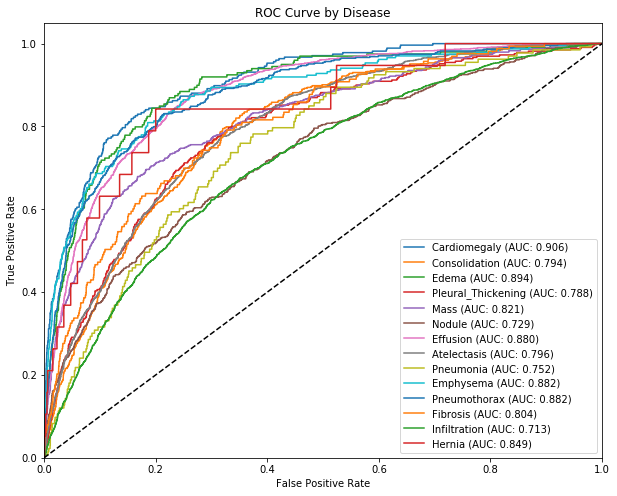

In [129]:
plot_auc_curves(epoch_evals[6]['val'])

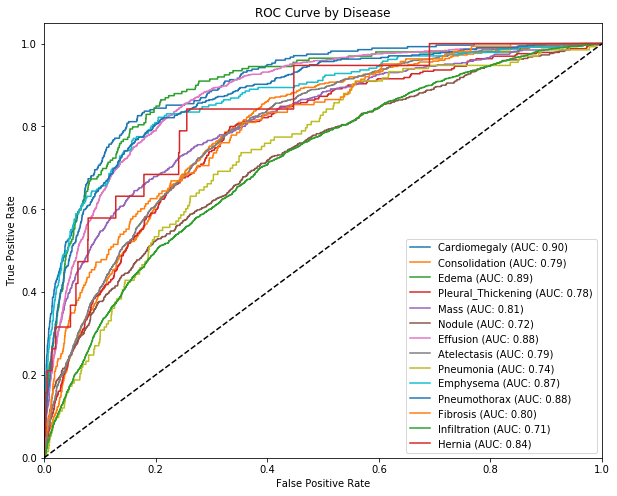

In [119]:
plot_auc_curves(epoch_evals[4]['val'])

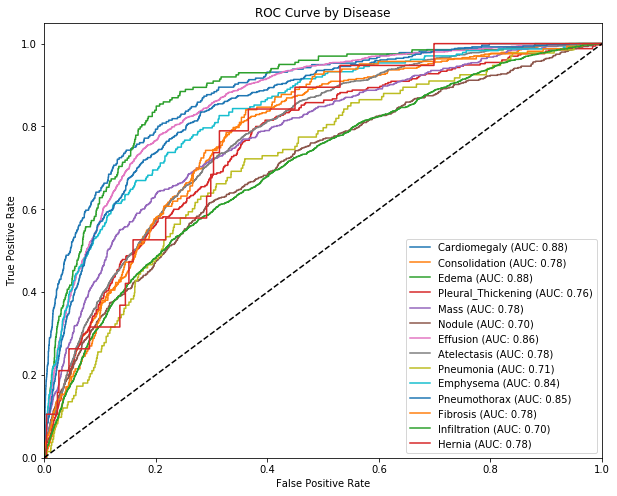

In [103]:
plot_auc_curves(epoch_evals[0]['val'])

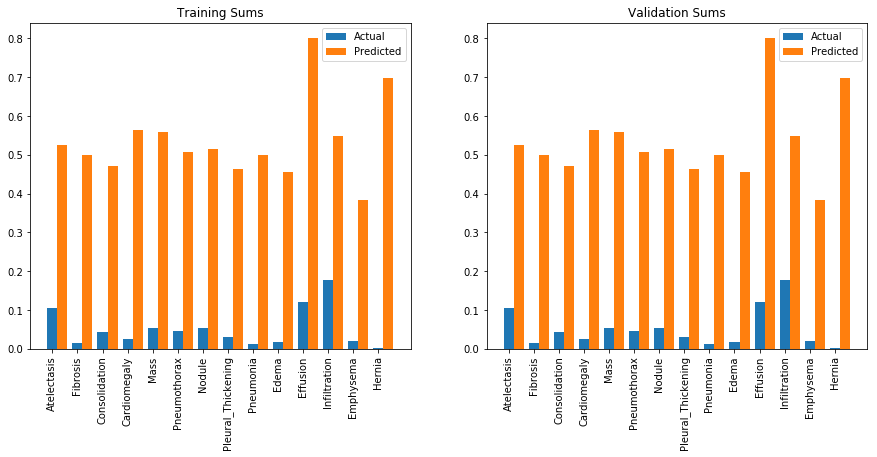

In [117]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Training Sums")
plot_compare_sums(eval_val)

plt.subplot(1,2,2)
plt.title("Validation Sums")
plot_compare_sums(eval_val)

In [54]:
out_model_30.train(mode=False)

obs_counter = 0
total_pred = Variable(torch.FloatTensor(torch.zeros(14)))
total_act = Variable(torch.FloatTensor(torch.zeros(14)))

conf_a = {}
conf_b = {}
conf_c = {}
conf_d = {}
for i in range(1,10):
    conf_a[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_b[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_c[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_d[i] = Variable(torch.FloatTensor(torch.zeros(14)))

for data in dataloaders['val']:
    print("STARTING ITERATION...")
    inputs, labels = data
    print("PROCESSING FIRST {} OBSERVATIONS".format(len(inputs)))

    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    outputs = out_model_30(inputs).sigmoid()
    
    total_act += labels.sum(0).cpu()
    total_pred += outputs.sum(0).cpu()

    # Store statistics (convert from autograd.Variable to float/int)
    for i in range(1,10):
        t = i/10
        conf_a[i] += ((outputs.sigmoid()>t) == (labels>0.5)).sum(0).cpu().float()
        conf_b[i] += ((outputs.sigmoid()<t) == (labels>0.5)).sum(0).cpu().float()
        conf_c[i] += ((outputs.sigmoid()>t) == (labels<0.5)).sum(0).cpu().float()
        conf_d[i] += ((outputs.sigmoid()<t) == (labels<0.5)).sum(0).cpu().float()

    obs_counter += len(inputs)

STARTING ITERATION...
PROCESSING FIRST 750 OBSERVATIONS
STARTING ITERATION...
PROCESSING FIRST 406 OBSERVATIONS


In [67]:
comparison = Variable(torch.FloatTensor(9, 14))
for i in range(9):
    comparison[0] = conf_a[1] / obs_counter
print(comparison.int())

Variable containing:

Columns 0 to 5 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 6.2634e+06 -1.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

Columns 6 to 11 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -6.5460e+04  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
-2.1475e

In [101]:
'''
torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
'''
test_load = torch.load('/user/xrayproj/output/20171120-01h41m56s_model_9.tar')

In [103]:
test_load.keys()

dict_keys(['epoch', 'state', 'optimizer', 'scheduler', 'val_error'])

In [106]:
load_opt = test_load['optimizer']
load_sched = test_load['scheduler']
load_state = test_load['state']

In [117]:
model2 = models.resnet18(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Replace FC layer
model2.fc = nn.Linear(model2.fc.in_features, len(img_data_train.labels))

model2_c = DataParallel(model2).cuda()

In [118]:
model2_c.load_state_dict(load_state)

In [123]:
model2_c.forward(Variable(img_data_train[0][0].unsqueeze(0).cuda())).sigmoid()

Variable containing:

Columns 0 to 9 
 0.7873  0.5093  0.2980  0.6386  0.4665  0.3371  0.1614  0.1846  0.1925  0.6630

Columns 10 to 13 
 0.0288  0.4468  0.3684  0.2549
[torch.cuda.FloatTensor of size 1x14 (GPU 0)]

In [ ]:
def single_model_run(model, dataset):
    dataset
    for data in self.dataset:
        inputs, actuals = data

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()

        self.m_total_sums.update(preds, actuals)
        self.m_auc.add(preds, actuals)